In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import kmapper as km
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")
import networkx as nx
import ripser
import persim
import sys
import networkx as nx
import evaluate


# Cargar las bases de datos

In [2]:
tag2024 = pd.read_excel('TAGS/Consolidado Edenred 2024.xlsx', sheet_name='Detalle de Movimientos 2024')
tag2022 = pd.read_excel('TAGS/Edenred Consolidado 2022.xlsx', sheet_name='Detalle de Movimientos por Fact')
tag2023 = pd.read_excel('TAGS/Edenred Consolidado Diciembre 2023.xlsx', sheet_name='Detalle de Movimientos ')
tag2021 = pd.read_excel('TAGS/Edenred Fuel Consumption Consolidation 2021.xlsx', sheet_name='Detalle de Movimientos por Fact')

Concatenar los cuatro años de datos

In [5]:
tag = pd.concat([tag2021, tag2022, tag2023, tag2024], ignore_index=True)

Checar las columnas consistentes en todos los datasets

In [6]:
# check Common columns across all years
common_columns = set(tag2021.columns).intersection(tag2022.columns).intersection(tag2023.columns).intersection(tag2024.columns)
print(f'Columnas comunes: {common_columns}')
len(common_columns)
tag = tag[list(common_columns)]

Columnas comunes: {'IVA', 'Num Serie', 'Fecha Transacción', 'TON C02', 'Factura', 'Month', 'Razón Social Afiliado', 'KG C02', 'Folio', 'Km Transacción', 'Arboles', 'Comision', 'Km Ant Transacción', 'BL', 'No Estación Pemex', 'IEPS', 'Hora Transacción', 'Vehículo', 'Placa', 'Recorrido', 'Precio Unitario', 'Num Tarjeta', 'No Comprobante', 'Importe Transacción', 'Id Conductor', 'Número de Control', 'Id Mercancía', 'Conductor', 'Rendimiento Real', 'IVA %', 'Mercancía', 'Importe Neto', 'Id Grupo Región', 'Subtotal', 'Respuesta', 'Serie', 'RFC', 'Cliente', 'Observación', 'Cantidad Mercancía', 'Division', 'Id Región', 'Identificador Vehículo', 'Rendimiento'}


In [7]:
# Tamaño del dataset
print(f'Tamaño del dataset: {tag.shape[0]} filas y {tag.shape[1]} columnas')

Tamaño del dataset: 48769 filas y 44 columnas


Corregir inconsistencias y errores en la base de datos

In [8]:
# Corregir los valores que no están en el formato abreviado de mes
# Crear un diccionario para mapear los nombres de meses en diferentes formatos al formato abreviado en inglés
month_mapping = {
    'ene.': 'Jan', 'feb.': 'Feb', 'mar.': 'Mar', 'abr.': 'Apr', 'may.': 'May', 'jun.': 'Jun',
    'jul.': 'Jul', 'ago.': 'Aug', 'sep.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'dic.': 'Dec', 'Abr': 'Apr',
    'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Apr': 'Apr', 'May': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Aug': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dec': 'Dec'
}

# Corregir los valores de la columna 'Month' utilizando el mapeo
tag['Month'] = tag['Month'].apply(lambda x: month_mapping.get(x, pd.to_datetime(x, errors='coerce').strftime('%b') if pd.notnull(pd.to_datetime(x, errors='coerce')) else None))
tag['Month'] = tag['Month'].apply(lambda x: month_mapping.get(x, pd.to_datetime(x, errors='coerce').strftime('%b') if pd.notnull(pd.to_datetime(x, errors='coerce')) else None))

In [9]:
tag['Fecha Transacción'] = pd.to_datetime(tag['Fecha Transacción'], format='%d/%m/%Y', errors='coerce')
# Convertir la columna 'Hora Transacción' al formato datetime.time
tag['Hora Transacción'] = pd.to_datetime(tag['Hora Transacción'], format='%H:%M:%S', errors='coerce').dt.time

# Variables a analizar

El analisis correspondiente a por que se eligieron estas columnas estan detalladas en la etapa 2

In [10]:
# Definir las columnas que se desean conservar
columnsToKeep = [
       'Month', 'Id Región',
       'Division', 'BL', 'Identificador Vehículo', 'Vehículo', 'Placa', 
       'Num Tarjeta', 'Num Serie', 'Fecha Transacción', 'Hora Transacción', 
       'Id Mercancía', 'Mercancía', 'Km Ant Transacción', 
       'Km Transacción', 'Recorrido',
       'Importe Transacción', 'Cantidad Mercancía', 
       'KG C02', 'Arboles', 'Precio Unitario', 'Rendimiento', 
       'Rendimiento Real', 
       # 'Id Conductor', 'Observación', 
       'Respuesta']

In [11]:
cuantitativas = ['Km Ant Transacción',
                'Km Transacción',
                'Recorrido',
                'Importe Transacción',
                'Cantidad Mercancía',
                'KG C02',
                'Arboles',
                'Precio Unitario',
                'Rendimiento',
                'Rendimiento Real']
cualitativas = ['Month',
                'Id Región',
                'Division',
                'BL',
                'Identificador Vehículo',
                'Vehículo',
                'Placa',
                'Num Tarjeta',
                'Num Serie',
                'Fecha Transacción',
                'Hora Transacción',
                'Id Mercancía',
                'Mercancía',
                # 'Id Conductor',
                # 'Observación',
                'Respuesta']

In [12]:
tag = tag[columnsToKeep]

# Limpieza de datos

In [13]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48769 entries, 0 to 48768
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   48769 non-null  object        
 1   Id Región               48764 non-null  object        
 2   Division                48769 non-null  object        
 3   BL                      48769 non-null  object        
 4   Identificador Vehículo  48769 non-null  object        
 5   Vehículo                48769 non-null  object        
 6   Placa                   48769 non-null  object        
 7   Num Tarjeta             48769 non-null  int64         
 8   Num Serie               48769 non-null  object        
 9   Fecha Transacción       48392 non-null  datetime64[ns]
 10  Hora Transacción        48355 non-null  object        
 11  Id Mercancía            48769 non-null  int64         
 12  Mercancía               48769 non-null  object

Nota: al quitar los nulos se pierden muchos datos (casi 10000 filas), para futuras pruebas, podemos quitar las variables cualitativas 'Id Conductor' y 'Observacion', que son las que tienen mas valores nulos, a ver si asi perdemos menos cantidad de datos

In [14]:
# Quitar valores nulos
tag = tag.dropna()

In [15]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47337 entries, 7 to 48267
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   47337 non-null  object        
 1   Id Región               47337 non-null  object        
 2   Division                47337 non-null  object        
 3   BL                      47337 non-null  object        
 4   Identificador Vehículo  47337 non-null  object        
 5   Vehículo                47337 non-null  object        
 6   Placa                   47337 non-null  object        
 7   Num Tarjeta             47337 non-null  int64         
 8   Num Serie               47337 non-null  object        
 9   Fecha Transacción       47337 non-null  datetime64[ns]
 10  Hora Transacción        47337 non-null  object        
 11  Id Mercancía            47337 non-null  int64         
 12  Mercancía               47337 non-null  object     

En el caso de las variables cuantitativas, revisar que los datos tengan sentido y que esten limpios y de buena calidad, observamos que:

- 'Recorrido' tiene valores negativos (imposible)
- 'Rendimiento real' tiene valores negativos (imposible)

In [16]:
tag[cuantitativas].describe().transpose()

count           mean            std           min  \
Km Ant Transacción   47337.0  142615.148974  453746.886501  0.000000e+00   
Km Transacción       47337.0  145135.316898  464226.507596  0.000000e+00   
Recorrido            47337.0    2520.167924  193656.085488 -9.750948e+06   
Importe Transacción  47337.0    2032.563575    2411.693766  2.319000e+01   
Cantidad Mercancía   47337.0      91.466853     102.102987  1.000000e+00   
KG C02               47337.0     219.905217     246.793481  2.421000e+00   
Arboles              47337.0      14.660348      16.452899  1.614000e-01   
Precio Unitario      47337.0      21.814363       8.166429  2.005176e+00   
Rendimiento          47337.0      12.277290       3.164694  1.000000e-02   
Rendimiento Real     47337.0     -62.098012   17766.115928 -3.666055e+06   

                             25%           50%            75%           max  
Km Ant Transacción   40440.00000  86692.000000  135179.000000  9.850034e+06  
Km Transacción       41035.00000  87132.000000  135833.000000  9.850034e+06  
Recorrido              156.00000    284.000000     445.000000  9.751982e+06  
Importe Transacción    994.50000   1399.900000    1834.520000  2.434409e+04  
Cantidad Mercancía      46.58151     65.373673      83.601739  1.000000e+03  
KG C02                 111.36600    157.389210     201.006531  2.421000e+03  
Arboles                  7.42440     10.492614      13.400435  1.614000e+02  
Precio Unitario         20.19000     21.831631      22.804784  1.111575e+03  
Rendimiento             10.00000     14.000000      14.000000  2.434000e+01  
Rendimiento Real         2.31000      4.900000       8.040000  5.414736e+05

In [17]:
# Revisar cuantos valores de 'Recorrido' son negativos
recorrido_negativos = tag[tag['Recorrido'] < 0]
print(f'Cantidad de recorridos negativos: {recorrido_negativos.shape[0]}')

Cantidad de recorridos negativos: 1720


In [18]:
# Revisar cuantos valores de 'Rendimiento Real' son negativos
rendimiento_real_negativos = tag[tag['Rendimiento Real'] < 0]
print(f'Cantidad de rendimientos reales negativos: {rendimiento_real_negativos.shape[0]}')

Cantidad de rendimientos reales negativos: 1700


In [19]:
# Drop the negative values
tag = tag[tag['Recorrido'] >= 0]
tag = tag[tag['Rendimiento Real'] >= 0]

Implementar un metodo de deteccion de outliers (en mi caso el z-score) y revisar nuevamente nuestra base de datos

In [20]:
for column in cuantitativas:
    z_scores = stats.zscore(tag[column].dropna())
    outliers = tag[abs(z_scores) > 3]
    print(f'Cantidad de outliers en {column}: {outliers.shape[0]}')

Cantidad de outliers en Km Ant Transacción: 382
Cantidad de outliers en Km Transacción: 416
Cantidad de outliers en Recorrido: 241
Cantidad de outliers en Importe Transacción: 1352
Cantidad de outliers en Cantidad Mercancía: 1277
Cantidad de outliers en KG C02: 1291
Cantidad de outliers en Arboles: 1291
Cantidad de outliers en Precio Unitario: 84
Cantidad de outliers en Rendimiento: 334
Cantidad de outliers en Rendimiento Real: 176


In [21]:
for column in cuantitativas:
    z_scores = stats.zscore(tag[column].dropna())
    outliers = tag[abs(z_scores) > 3]
    # Drop the outliers
    tag = tag[abs(z_scores) <= 3]

In [22]:
tag[cuantitativas].describe().transpose()

count          mean           std        min  \
Km Ant Transacción   38812.0  93467.806323  74601.841099   0.000000   
Km Transacción       38812.0  93854.621663  74618.007468   0.000000   
Recorrido            38812.0    386.815341    876.011451   0.000000   
Importe Transacción  38812.0   1317.922577    518.500691  23.740000   
Cantidad Mercancía   38812.0     61.609144     23.043908   1.000000   
KG C02               38812.0    148.628604     55.700159   2.421000   
Arboles              38812.0      9.908574      3.713344   0.161400   
Precio Unitario      38812.0     21.389053      1.805973   4.143953   
Rendimiento          38812.0     12.183020      3.003923   3.000000   
Rendimiento Real     38812.0      7.569871     14.747003   0.000000   

                              25%           50%            75%            max  
Km Ant Transacción   40094.500000  83628.500000  128465.500000  720260.000000  
Km Transacción       40509.750000  83932.000000  128794.250000  720310.000000  
Recorrido              177.000000    289.000000     425.000000   34445.000000  
Importe Transacción    942.532044   1307.792000    1641.985000    3761.901359  
Cantidad Mercancía      44.747500     61.040000      78.384968     135.572799  
KG C02                 107.661870    147.245220     189.158782     328.221746  
Arboles                  7.177458      9.816348      12.610585      21.881450  
Precio Unitario         19.990000     21.609991      22.510587      41.055408  
Rendimiento             10.000000     14.000000      14.000000      21.650000  
Rendimiento Real         3.160000      5.410000       8.130000     281.460000

<Figure size 2000x2000 with 0 Axes>

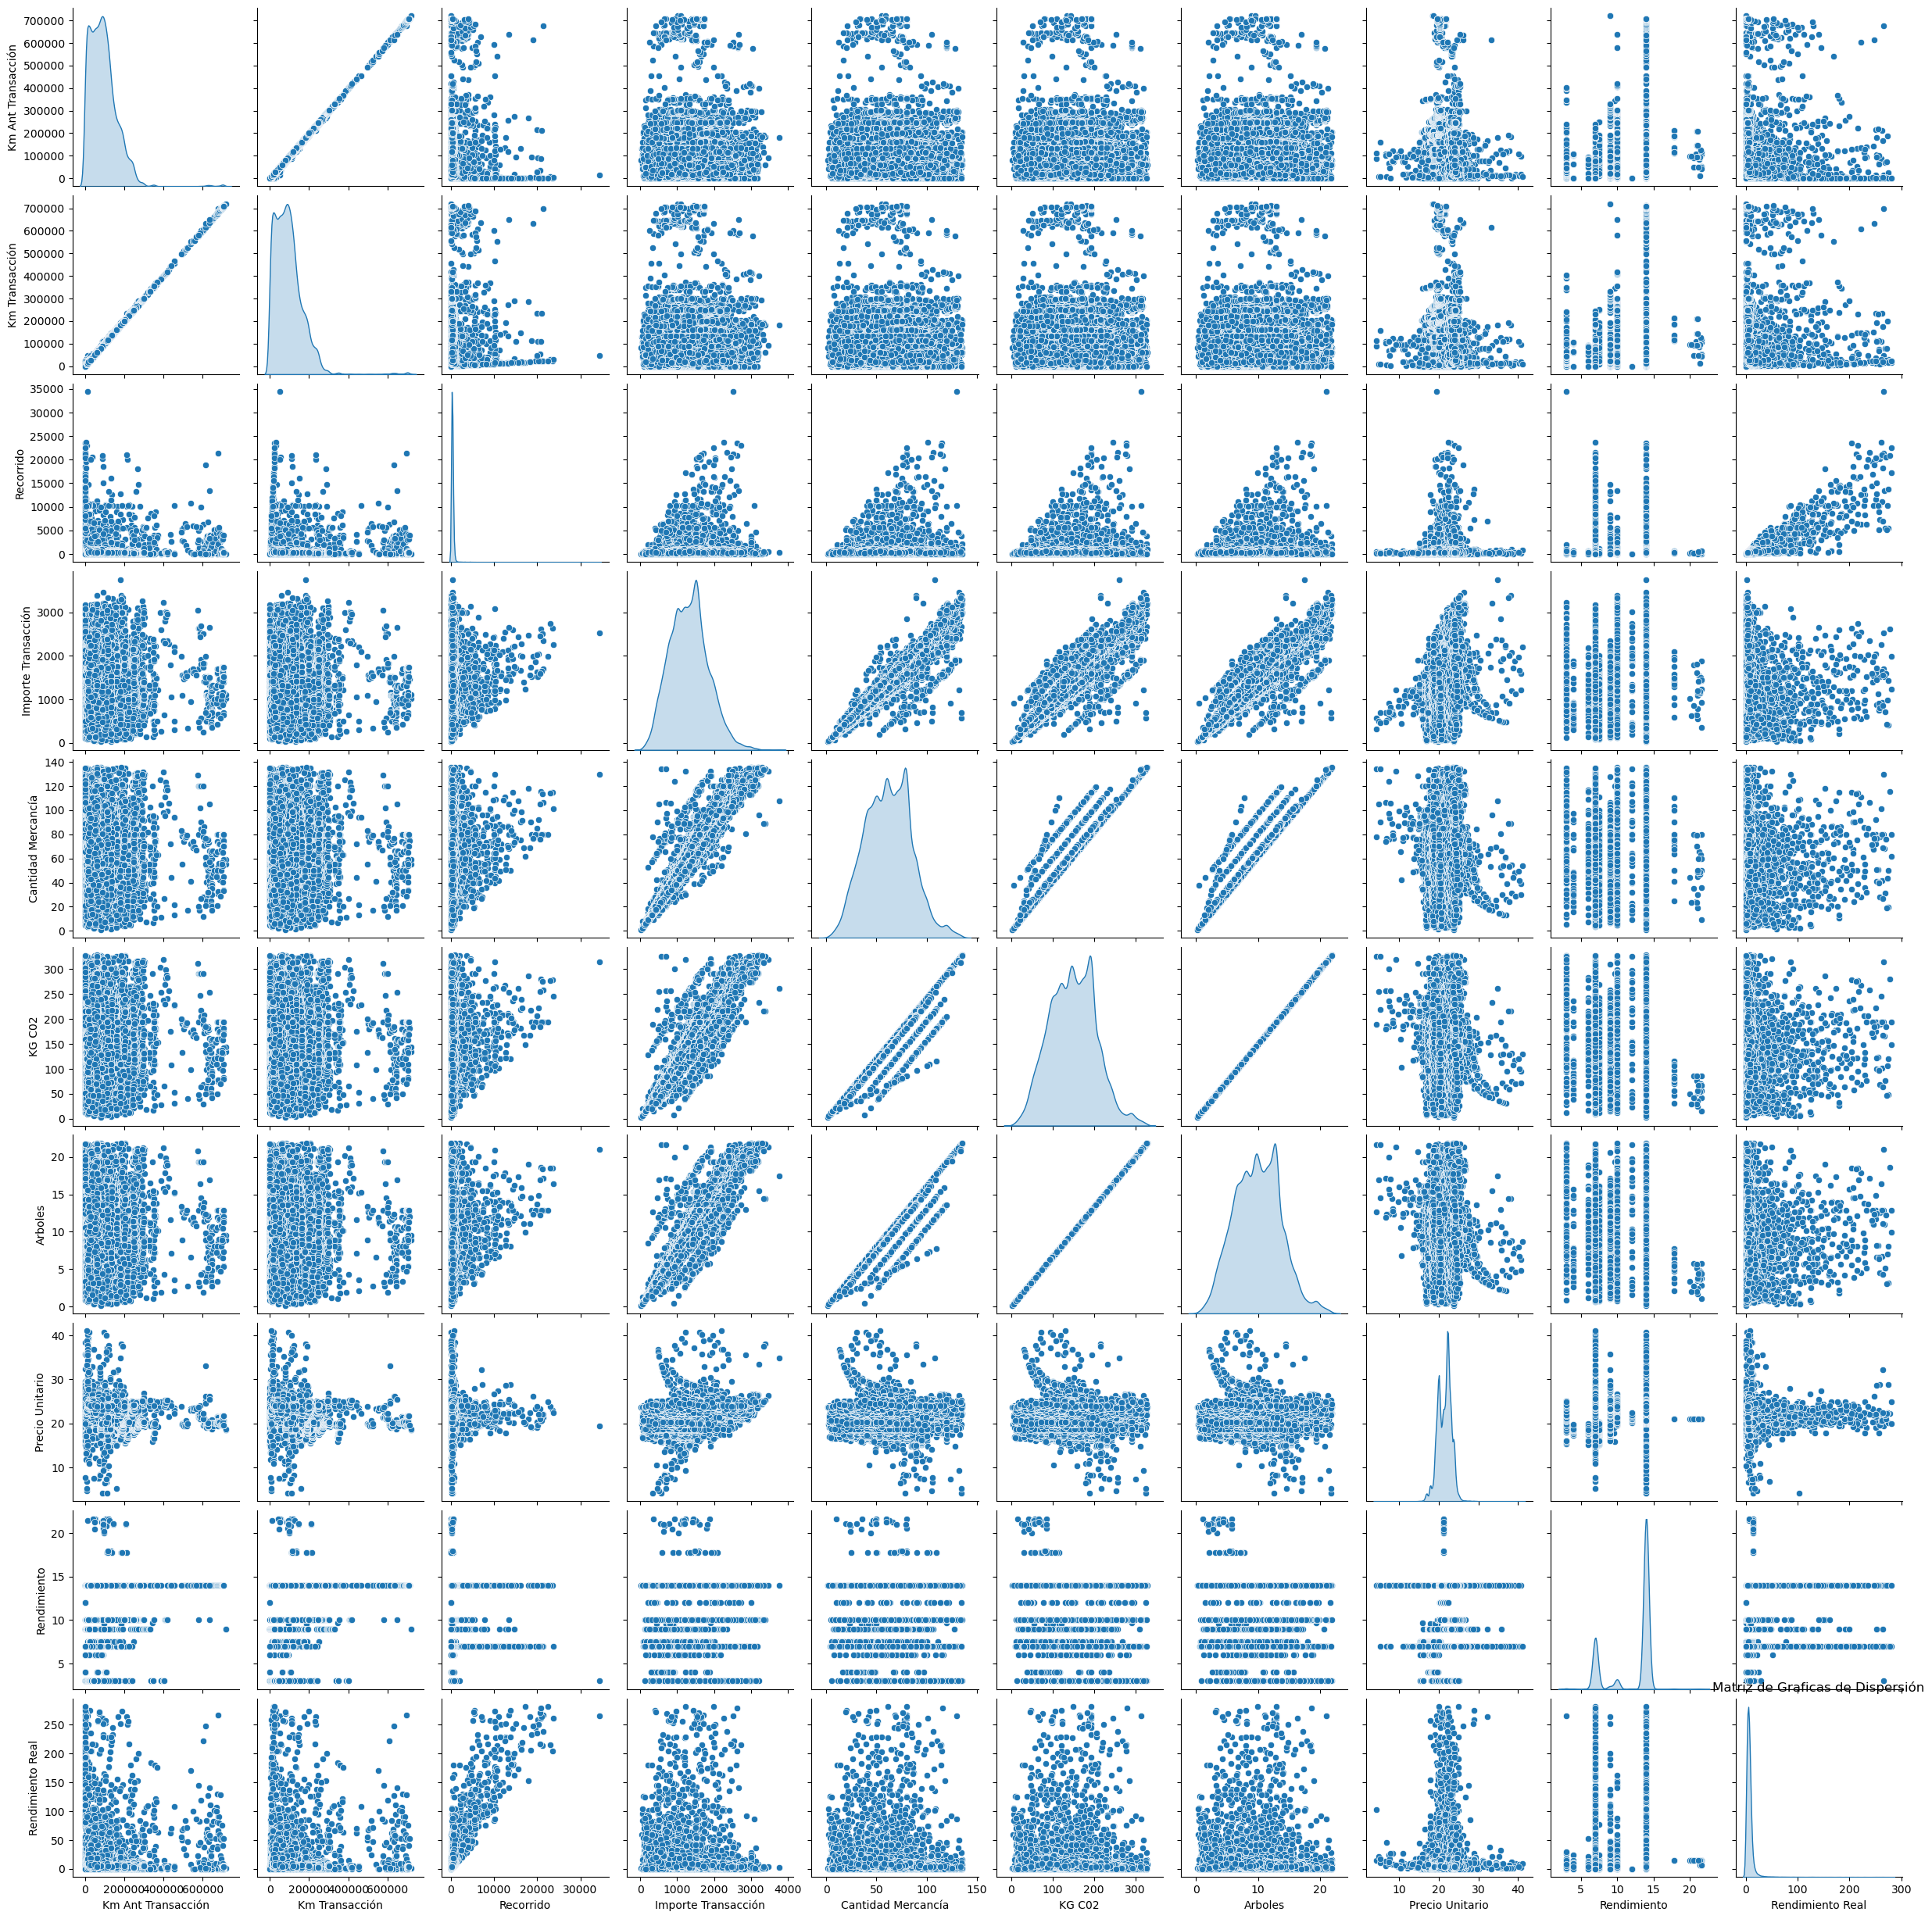

In [23]:
plt.figure(figsize=(20, 20))
sns.pairplot(tag[cuantitativas], diag_kind='kde')
plt.title('Matriz de Graficas de Dispersión')
plt.savefig('TAGS/Matriz de Graficas de Dispersión.png', dpi=300, bbox_inches='tight')
plt.show()

# Escalado de los datos

In [24]:
tag.reset_index(drop=True, inplace=True)
X = tag[cuantitativas].copy()
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

In [25]:
mapper = km.KeplerMapper(verbose=1)
lens = PCA(n_components=2).fit_transform(X_scaled) 

KeplerMapper(verbose=1)


Text(0, 0.5, 'PCA Component 2')

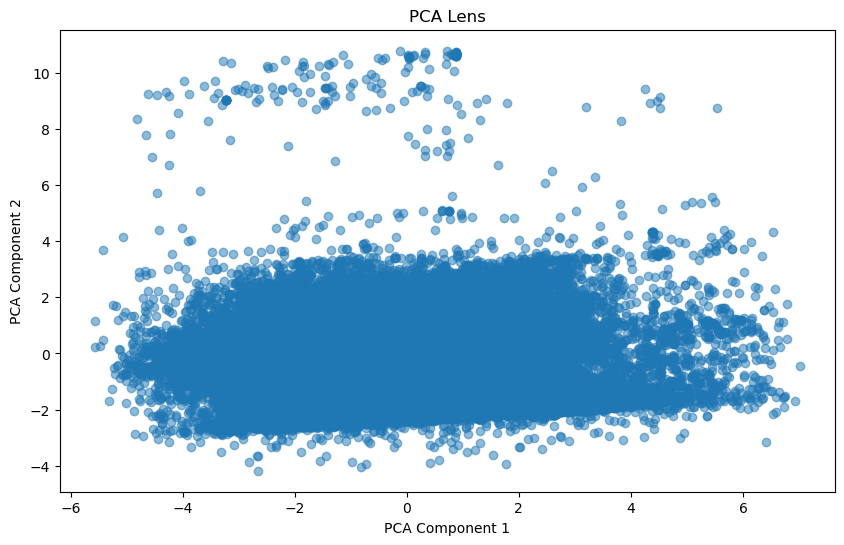

In [26]:
# Plot the PCA lens
plt.figure(figsize=(10, 6))
plt.scatter(lens[:, 0], lens[:, 1], alpha=0.5)
plt.title('PCA Lens')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Mapper

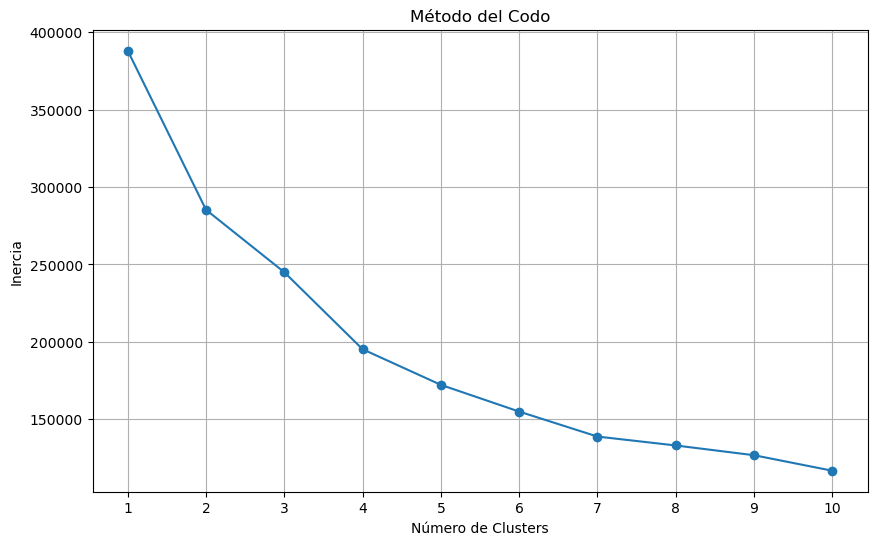

In [27]:
# Metodo del codo para determinar el número óptimo de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

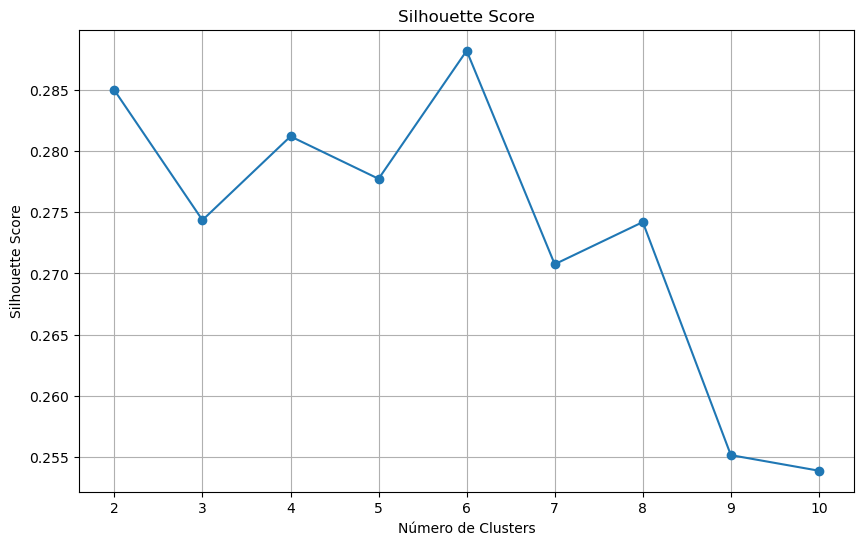

In [28]:
# Silhouette Score para determinar el número óptimo de clusters
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [29]:
graph = mapper.map(
    lens,  # datos de entrada
    X_scaled,  # datos originales
    clusterer=KMeans(n_clusters=6, random_state=12),  # algoritmo de agrupamiento
    cover=km.Cover(n_cubes=4, perc_overlap=0.09),  # cubos y superposición
)

# Visualizar el grafo
html_output = mapper.visualize(
    graph,
    title="Mapper Problema 3",
    X = X.values,
    X_names = X.columns.tolist(),
    custom_tooltips=(
        tag['Identificador Vehículo']
    ),
    color_values=tag[['KG C02', 'Arboles', 'Rendimiento', 'Rendimiento Real']],
    color_function_name=['KG C02', 'Arboles', 'Rendimiento', 'Rendimiento Real'],
    node_color_function=['mean', 'max', 'min'],
    nbins=10,
    include_searchbar=True,
    include_min_intersection_selector=True,
    path_html="TAGS.html",
    # color_values=skills['value_eur'],
    # color_function_name="Value in Euros",
)

Mapping on data shaped (38812, 10) using lens shaped (38812, 2)

Creating 16 hypercubes.

Created 175 edges and 96 nodes in 0:00:00.407267.
Wrote visualization to: TAGS.html


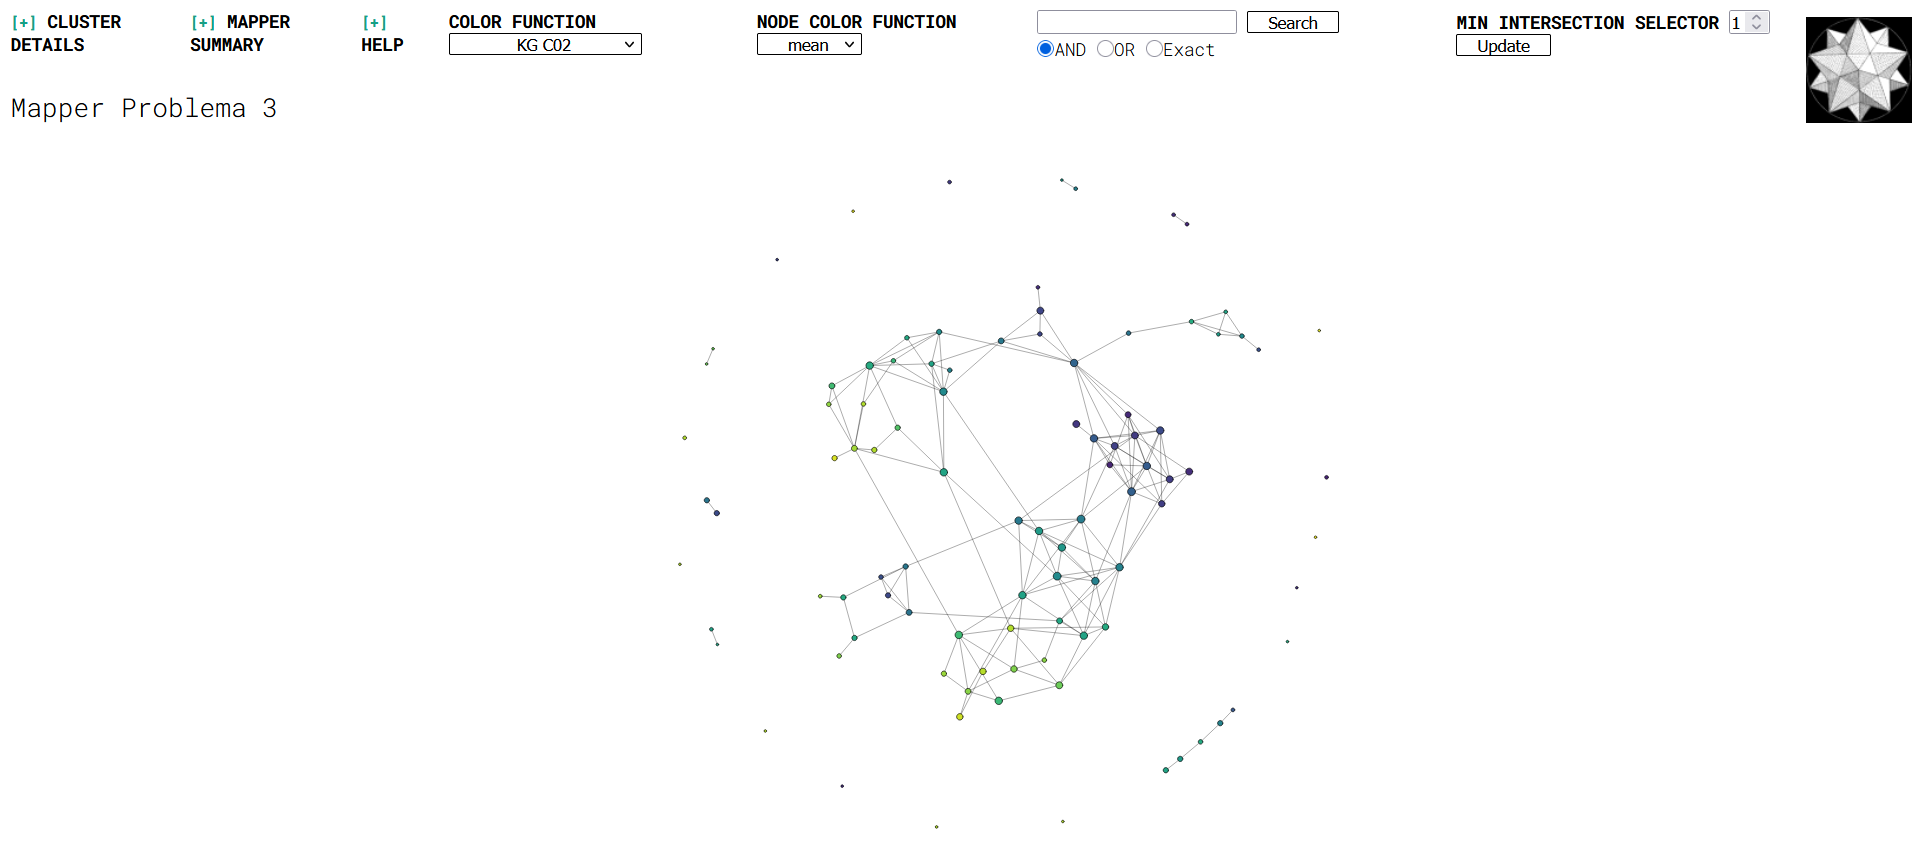

Utilizaremos "Identificador Vehiculo" como el id unico de los vehiculos, a pesar de haber varios tipos de identificadores, de los cuales tenemos poca informacion, el mas consistente es el antes ya mencionado

## Grafico de persistencia

Forma de los datos escalados y muestreados: (1000, 10)


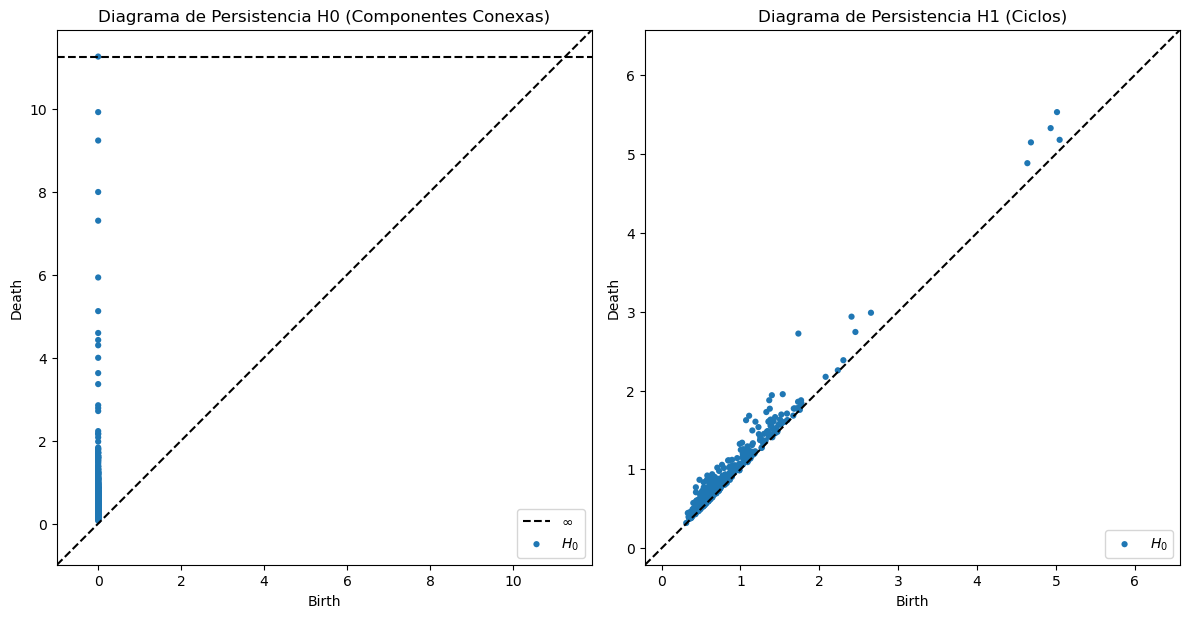

In [30]:
# 3. Muestreo
# Tomar una muestra aleatoria
sample_size = min(1000, len(X_scaled))
np.random.seed(42) # Para reproducibilidad
sample_indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
data_sample = X_scaled[sample_indices,:]

print(f"Forma de los datos escalados y muestreados: {data_sample.shape}")

# 4. Cálculo de Diagramas de Persistencia
diagrams = ripser.ripser(data_sample, maxdim=1, thresh=np.inf)['dgms']

# 5. Visualización
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
persim.plot_diagrams(diagrams[0], show=False, ax=plt.gca(), legend=True) # Added legend=True
plt.title("Diagrama de Persistencia H0 (Componentes Conexas)")

plt.subplot(1, 2, 2)
persim.plot_diagrams(diagrams[1], show=False, ax=plt.gca(), legend=True) # Added legend=True
plt.title("Diagrama de Persistencia H1 (Ciclos)")

plt.tight_layout()
plt.show()

## D-Mapper

Convertimos nuestro dataset X a un numpy array por cuestiones de compatibilidad de tipo de variables

In [31]:
X_array = np.array(X)

Definimos nuestro D-mapper, nuestro filtro sera de dimension 1

In [32]:
dmapper = km.D_Mapper(verbose=2)
projected_data = dmapper.fit_transform(X_array)

D_Mapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (38812, 10)

..Projecting data using: sum

..Scaling with: MinMaxScaler()



Graficamos la dimension de nuestro filtro como una distribucion de densidad

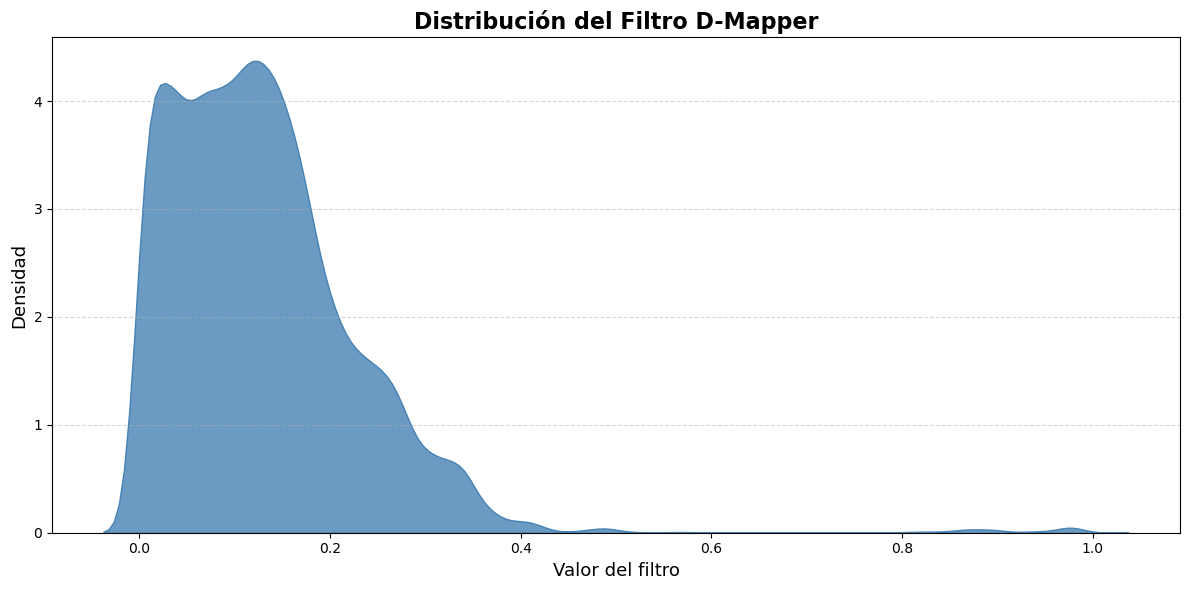

In [33]:
# plot the projected data as a histogram

plt.figure(figsize=(12, 6))
sns.kdeplot(projected_data.flatten(), fill=True, color='#4682B4', alpha=0.8)
plt.title('Distribución del Filtro D-Mapper', fontsize=16, fontweight='bold')
plt.xlabel('Valor del filtro', fontsize=13)
plt.ylabel('Densidad', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Algoritmo de nuestro D-Mapper, elegimos un n=numero de cubes, a=alpha, realice pruebas con DBSCAN y K-means

Mapping on data shaped (38812, 10) using lens shaped (38812, 1)



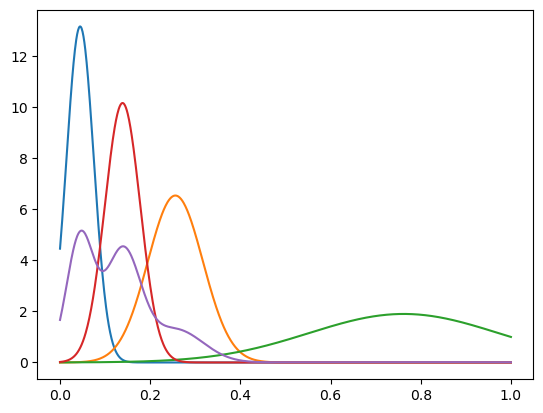

 - Cover - centers: [np.float64(0.05198188244705574), np.float64(0.13871384250340324), np.float64(0.2558269806344479), np.float64(0.675506822313019)]
inner_range: [0.75]
radius: [np.float64(0.05198188244705574), np.float64(0.07691363919733955), np.float64(0.11952707662319506), np.float64(0.32449317768698105)]
bic:-82075.78101269316
alpha_max:0.06
Minimal points in hypercube before clustering: 3
Creating 4 hypercubes.
   > Found 3 clusters in hypercube 0.
   > Found 3 clusters in hypercube 1.
   > Found 3 clusters in hypercube 2.
   > Found 3 clusters in hypercube 3.

Created 18 edges and 12 nodes in 0:00:02.305959.


In [34]:
n = 4
a = 0.05
clusterer = KMeans(n_clusters=3, random_state=12)
cover = km.D_Cover(n_cubes = n, alpha = a,max_iter=200000,n_init=10,verbose=1)
graphD = dmapper.map(
    projected_data,
    X_scaled,
    clusterer=KMeans(n_clusters=3, random_state=12),
    # clusterer = DBSCAN(eps=0.1, min_samples=2),
    cover= cover
)
interval_table_1 = cover.interval_table

Visualizamos el grafo

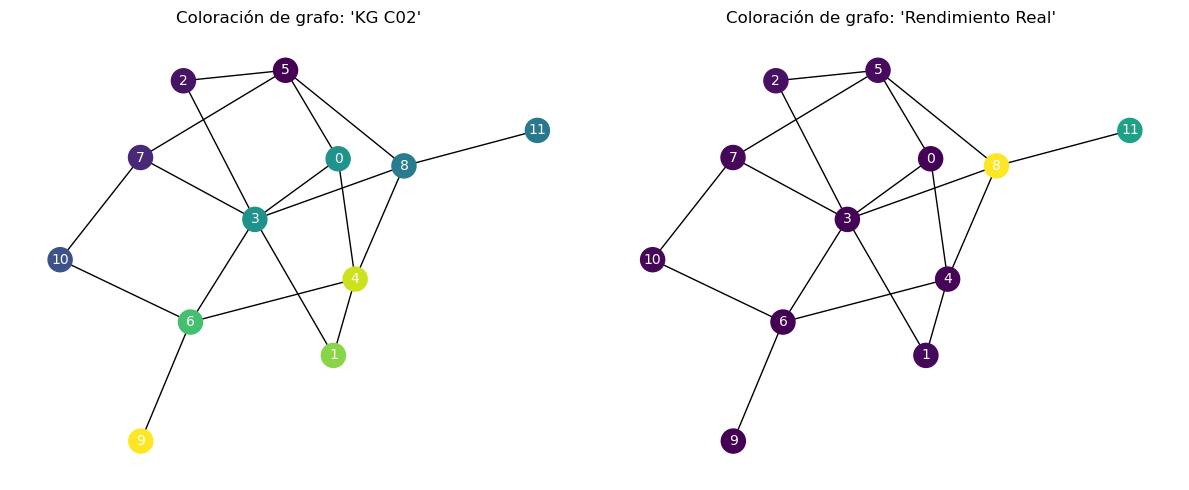

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer grafo: color por 'KG C02'
color_list1 = []
for i in range(len(graphD['nodes'])):
    index_list = list(graphD['nodes'].values())[i]
    color = np.mean(tag['KG C02'].iloc[index_list])
    color_list1.append(color)
G1 = km.adapter.to_networkx(graphD)
nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_color=color_list1, node_size=300, ax=axs[0])
nx.draw_networkx_labels(G1, pos=nx.kamada_kawai_layout(G1), labels= {n: i for i,n in enumerate(G1)},
                        font_color="White", font_size=10, ax=axs[0])
axs[0].set_title("Coloración de grafo: 'KG C02'")

# Segundo grafo: color por 'Rendimiento Real'
color_list2 = []
for i in range(len(graphD['nodes'])):
    index_list = list(graphD['nodes'].values())[i]
    color = np.mean(tag['Rendimiento Real'].iloc[index_list])
    color_list2.append(color)
nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_color=color_list2, node_size=300, ax=axs[1])
nx.draw_networkx_labels(G1, pos=nx.kamada_kawai_layout(G1), labels= {n: i for i,n in enumerate(G1)},
                        font_color="White", font_size=10, ax=axs[1])
axs[1].set_title("Coloración de grafo: 'Rendimiento Real'")

plt.tight_layout()
plt.savefig('Coloración de grafo.png', dpi=300, bbox_inches='tight')
plt.show()

Guardamos la informacion de los miembros de cada nodo en un dataset

In [36]:
car_id_list = list(tag['Identificador Vehículo'])
node_id_list = [n for n in enumerate(G1)]

df = pd.DataFrame(0,index=car_id_list, columns= [i for i, n in enumerate(G1)])

for i,node_id in node_id_list:
    id_list = graphD['nodes'][node_id]
    print(f'node: {node_id}: {id_list}')
    df[i].iloc[id_list] = 1
    
# Dropear indices repetidos
df = df.groupby(df.index).mean()
df['cluster'] = df.idxmax(axis=1)

node: cube0_cluster0: [13, 16, 23, 26, 28, 42, 47, 49, 54, 66, 75, 76, 84, 89, 98, 101, 104, 108, 115, 116, 120, 121, 123, 127, 132, 134, 135, 141, 152, 155, 156, 157, 159, 160, 161, 162, 163, 164, 169, 170, 180, 185, 190, 203, 204, 205, 207, 208, 211, 220, 225, 234, 236, 245, 248, 249, 253, 261, 265, 266, 267, 268, 271, 273, 276, 277, 278, 282, 292, 295, 297, 298, 303, 310, 311, 314, 323, 332, 334, 337, 339, 340, 341, 345, 346, 351, 352, 359, 366, 369, 374, 376, 380, 383, 391, 392, 398, 402, 403, 407, 411, 415, 432, 435, 437, 441, 443, 449, 451, 455, 456, 460, 462, 463, 465, 476, 482, 484, 488, 499, 501, 503, 504, 506, 515, 516, 520, 521, 526, 531, 532, 537, 546, 547, 550, 553, 556, 558, 561, 563, 564, 566, 571, 577, 578, 586, 587, 597, 601, 605, 606, 607, 608, 614, 617, 629, 633, 636, 637, 639, 642, 645, 650, 653, 660, 663, 666, 668, 672, 675, 677, 680, 681, 682, 688, 690, 691, 697, 698, 699, 700, 701, 723, 755, 763, 787, 807, 830, 838, 840, 849, 856, 859, 875, 890, 891, 897, 900, 90

Estos son los valores promedio de KG CO2 de cada nodo

In [39]:
for i, valor in enumerate(color_list1):
    print(f"nodo {i}: {valor}")

nodo 0: 161.5808941043544
nodo 1: 206.2675826548565
nodo 2: 95.07698677538377
nodo 3: 160.83562044049992
nodo 4: 220.65257860855158
nodo 5: 88.05417476962316
nodo 6: 188.79806058947398
nodo 7: 104.62076704582668
nodo 8: 147.76420956572292
nodo 9: 231.49437389391085
nodo 10: 124.18285746627109
nodo 11: 146.2436970747154


Estos son los valores promedio de Rendimiento Real por cluster

In [40]:
for i, valor in enumerate(color_list2):
    print(f"nodo {i}: {valor}")

nodo 0: 5.37185960322651
nodo 1: 7.98532480155516
nodo 2: 10.869282700421943
nodo 3: 5.257939267015707
nodo 4: 5.751561804008909
nodo 5: 9.25976054732041
nodo 6: 4.449929828880955
nodo 7: 7.335583478144633
nodo 8: 165.8934920634921
nodo 9: 4.657350427350428
nodo 10: 7.355489130434783
nodo 11: 96.58


Estas metricas del promedio, desviacion estandar, minimo y maximo nos pueden ayudar para verificar que nodos perteneces a que tipo de cluster (rendimiento bueno, moderado o bajo)

In [41]:
tag['KG C02'].mean(), tag['KG C02'].std(), tag['KG C02'].min(), tag['KG C02'].max()

(np.float64(148.62860422593425), 55.700158919926025, 2.421, 328.2217461684782)

In [42]:
tag['Rendimiento Real'].mean(), tag['Rendimiento Real'].std(), tag['Rendimiento Real'].min(), tag['Rendimiento Real'].max()

(np.float64(7.5698711738637545), 14.747003354315183, 0.0, 281.46)

Metrica de evaluacion, suele tardar mucho

In [43]:
SC_adj = km.evaluate.compute_SC_adj(X_scaled, projected_data, graphD, km.D_Cover(n_cubes = n, alpha = a,max_iter=200000,n_init=10,verbose=0), type = 'd'
                                #  , cluster = DBSCAN(eps=0.1, min_samples=5))
                                , cluster = KMeans(n_clusters=3, random_state=12))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


SC:0.053724430167
SC_norm:0.5268622150835
TSR:0.08333333333333333
SC_adj:0.30509777420841666


In [44]:
minmax = MinMaxScaler()
scaled_lens = minmax.fit_transform(lens)

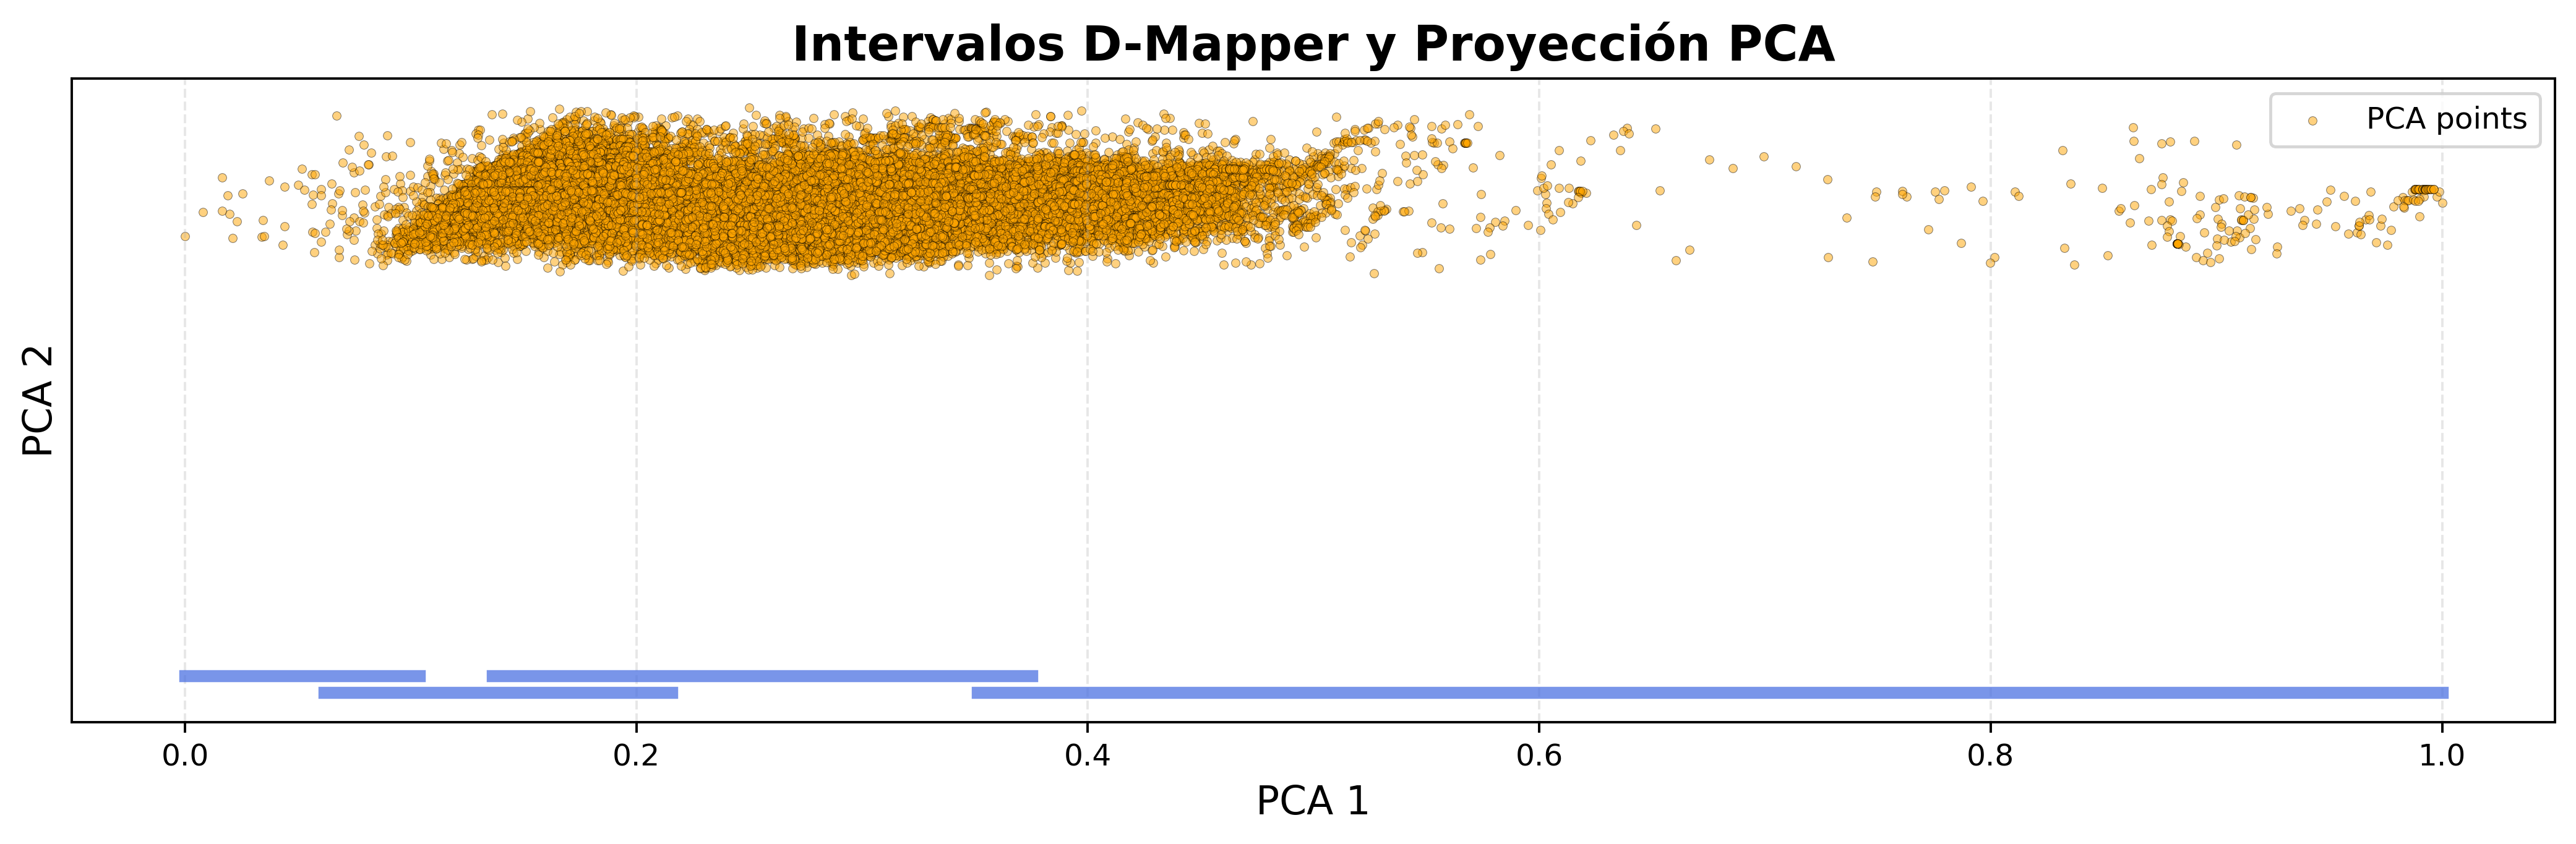

In [45]:
# Embellecer la gráfica de intervalos D-Mapper y puntos PCA

plt.figure(figsize=(12, 4), dpi=350)

# Dibujar los intervalos del D-Mapper
for i in range(1, interval_table_1.shape[1] + 1):
    plt.plot(
        [interval_table_1[0, i - 1], interval_table_1[1, i - 1]],
        [0.1 * (i % 2) - 2.5, 0.1 * (i % 2) - 2.5],
        color='royalblue', linewidth=4, alpha=0.7
    )

# Dibujar los puntos del PCA escalado
plt.scatter(
    scaled_lens[:, 1], scaled_lens[:, 0],
    s=8, c='orange', alpha=0.5, edgecolor='k', linewidth=0.2, label='PCA points'
)

plt.title('Intervalos D-Mapper y Proyección PCA', fontsize=16, fontweight='bold')
plt.xlabel('PCA 1', fontsize=13)
plt.ylabel('PCA 2', fontsize=13)
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()



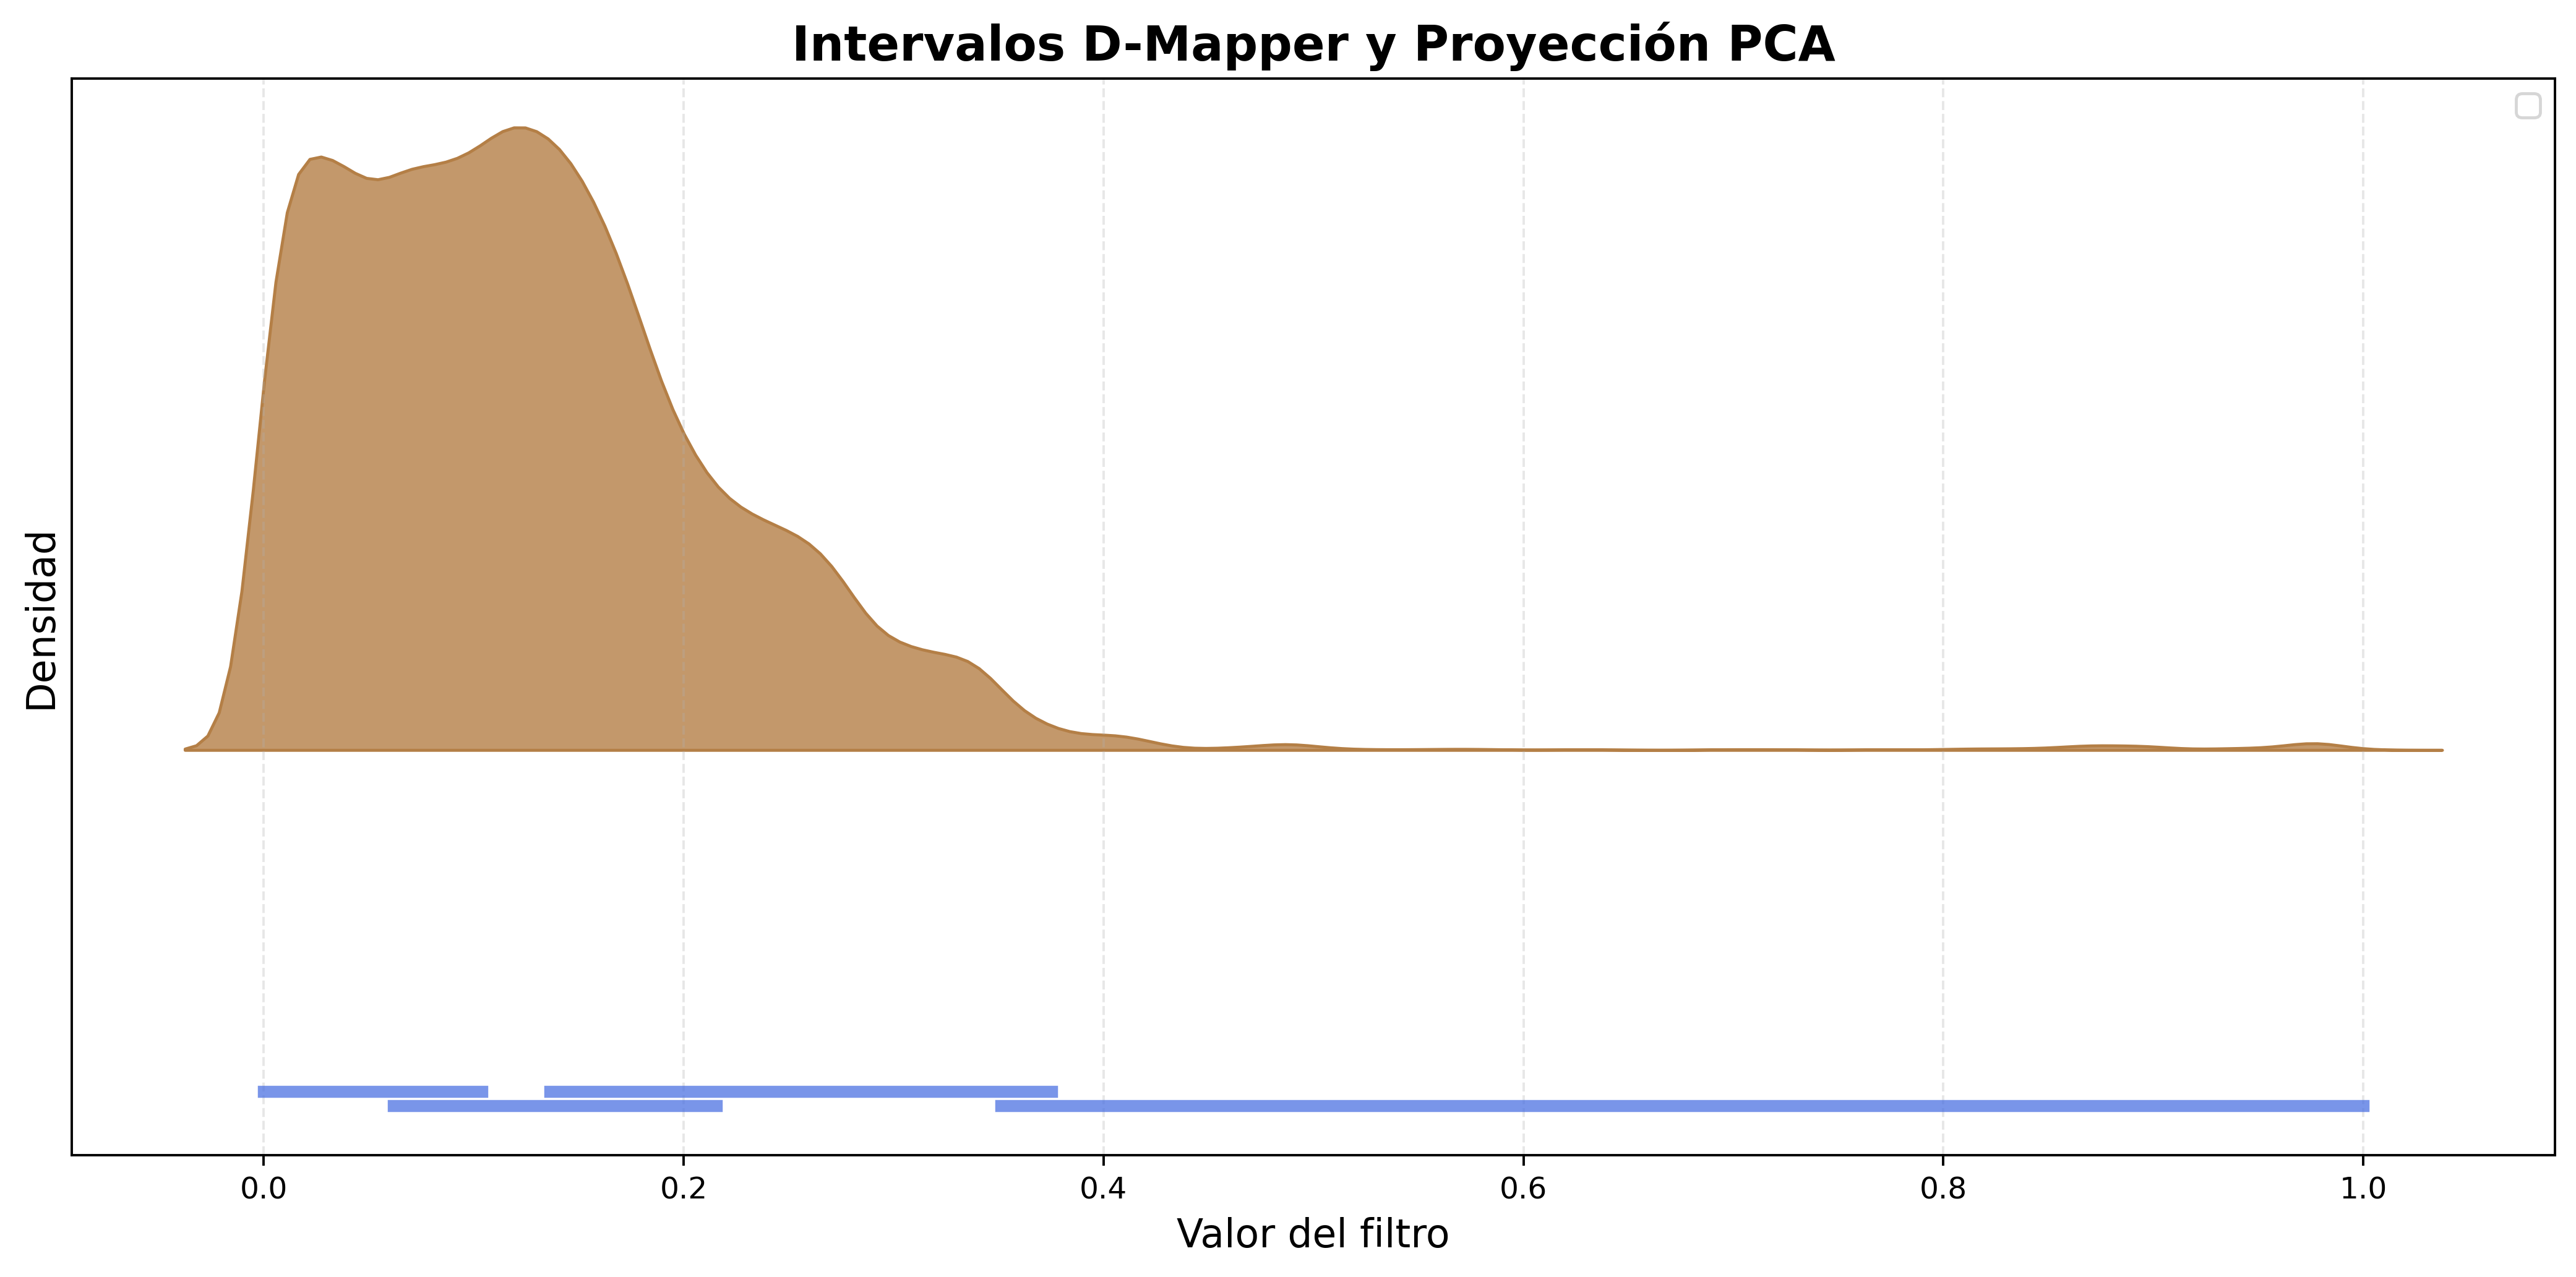

In [46]:
plt.figure(figsize=(12, 6), dpi=350)

# Dibujar los intervalos del D-Mapper
for i in range(1, interval_table_1.shape[1] + 1):
    plt.plot(
        [interval_table_1[0, i - 1], interval_table_1[1, i - 1]], # x-coordinates of line start and end
        [0.1 * (i % 2) - 2.5, 0.1 * (i % 2) - 2.5], # y-coordinates (same for start/end to make horizontal line)
        color='royalblue', # line color
        linewidth=4, # line thickness
        alpha=0.7 # transparency
    )

# Dibujar los puntos del PCA escalado
sns.kdeplot(projected_data.flatten(), fill=True, color="#B47F46", alpha=0.8)


plt.title('Intervalos D-Mapper y Proyección PCA', fontsize=16, fontweight='bold')
plt.xlabel('Valor del filtro', fontsize=13)
plt.ylabel('Densidad', fontsize=13)
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()



Obtener un reporte de los resultados

In [53]:
df.cluster.value_counts()

cluster
1     120
3      72
6      66
2      63
5      45
0      45
4      41
7      30
9      11
10      3
11      1
Name: count, dtype: int64

In [82]:
# Intersección de los índices
eficiente = df[(df[11] > 0) & (df[8] > 0)].index

# index donde el valor de cluster sea 1, 2, 5, 7 y 10
moderado = df[df['cluster'].isin([1, 2, 5, 7, 10])].index
# index donde el valor de cluster sea 0, 3, 4, 6 y 9
ineficiente = df[df['cluster'].isin([0, 3, 4, 6, 9])].index

# Quitar los index de inneficiente de moderado y eficiente
moderado = moderado.difference(eficiente)
ineficiente = ineficiente.difference(eficiente)


In [83]:
print(f'Cantidad de vehículos ineficientes: {len(ineficiente)}')
print(f'Cantidad de vehículos moderados: {len(moderado)}')
print(f'Cantidad de vehículos eficientes: {len(eficiente)}')

Cantidad de vehículos ineficientes: 233
Cantidad de vehículos moderados: 258
Cantidad de vehículos eficientes: 5


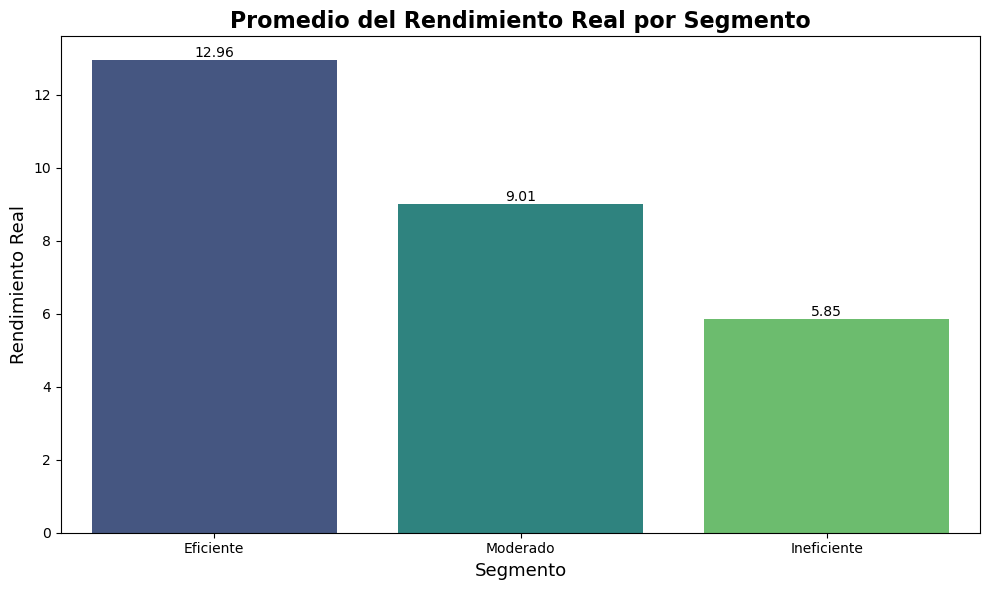

In [87]:
# Grafico de barras de el promedio del rendimiento real por cluster
# Calcular los promedios de rendimiento real por segmento
promedio_eficiente = tag[tag['Identificador Vehículo'].isin(eficiente)]['Rendimiento Real'].mean()
promedio_moderado = tag[tag['Identificador Vehículo'].isin(moderado)]['Rendimiento Real'].mean()
promedio_ineficiente = tag[tag['Identificador Vehículo'].isin(ineficiente)]['Rendimiento Real'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
segmentos = ['Eficiente', 'Moderado', 'Ineficiente']
promedios = [promedio_eficiente, promedio_moderado, promedio_ineficiente]

sns.barplot(x=segmentos, y=promedios, palette='viridis')
plt.title('Promedio del Rendimiento Real por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=13)
plt.ylabel('Rendimiento Real', fontsize=13)

# Agregar los valores sobre las barras
for i, v in enumerate(promedios):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()

In [88]:
eficiente

Index(['1CB6JKF47318', '1E50NFB38676', '3G60BEA29323', '5JP6PTC80173',
       '6A75K1D03523'],
      dtype='object')

In [89]:
moderado

Index(['04V59KA96110', '0BZ0MUA90533', '0BZ7MUA00584', '0BZ9NUA92718',
       '0BZXNUA71621', '0BZXNUA78424', '0F70DUC50399', '0F72DUD61634',
       '0F78DUB04932', '0F79DUB34635',
       ...
       'SBS', 'SEC-BATALLON', 'T0X4VD609990', 'T0X87M193162', 'TF110',
       'TMF1CB9JKD27', 'U9X0BD122453', 'WSV10', 'WSV101', 'XJFA11991'],
      dtype='object', length=258)

In [90]:
ineficiente

Index(['04V79KA54683', '0BZ3NUA78863', '116VH', '1335-VH', '144', '1547-PR',
       '1C81GKD98776', '1C83GKD98701', '1C83GKD98746', '1C87GKD98734',
       ...
       'MB12-REY', 'N0X2EF399612', 'N0X4EF399613', 'N9X3EF301657',
       'N9XXEF301476', 'T0X57D732517', 'T9XX7D650536', 'TC35052',
       'U0X89R252857', 'U0XX9J255581'],
      dtype='object', length=233)